# Задание
**Лабораторная работа №2**: Ядерные оценки плотности распределения
Цели и задачи л/р:
- [x] научиться строить ядерные оценки плотности распределения и гистограмму,
- [ ] оценить потери информации при построении оценок плотности распределения в сравнении с
эмпирической функцией распределения
- [ ] оценить статистическую точность оценок квантилей по
оценкам плотности в сравнении с оценками квантили по эмпирической функции распределения

# Лабораторная: KDE vs гистограмма vs ECDF

Требуется:
- Два распределения: N(0,1) и U[0,1]
- Размеры выборки: n = 10, 100, 1000, 10000
- Гистограмма: k ≈ 1 + 1.59 ln(n), ширина бинов одинаковая
- KDE: гауссовское ядро
- Квантили: 1%, 5%, 50% тремя способами (ECDF / гист / KDE)
- Повторы: N = 1000 для каждого (распределение, n)
- Оценить дисперсии оценок квантилей
- Оценить “потери информации” относительно ECDF (сравнение CDF)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

from scipy import stats
from scipy.interpolate import CubicSpline
from scipy.optimize import bisect
from scipy.special import kl_div

## Генерируем данные

In [18]:
np.random.seed(42)
data = np.random.normal(loc=0, scale=1, size=1000)

## Гистограмма и рассчёт ядерной оценки плотности (KDE)

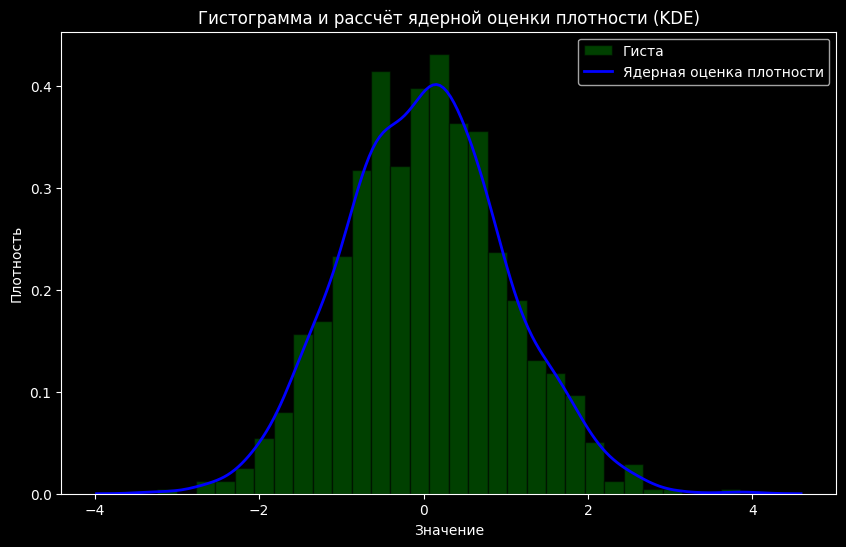

In [19]:
plt.figure(figsize=(10, 6))

plt.hist(data, bins=30, density=True, alpha=0.5, color='g', label='Гиста', edgecolor = 'black')

sns.kdeplot(data, color='b', label='Ядерная оценка плотности', lw=2)

plt.title('Гистограмма и рассчёт ядерной оценки плотности (KDE)')
plt.xlabel('Значение')
plt.ylabel('Плотность')
plt.legend()
plt.show()

По графику видим:
- гистограмма даёт оценку плотности, но она сильно зависит от интервалов
- KDE же в свою очередь даёт гладкую оценку плотности, которая зависит от ширины окна. при маленькой ширине у нас могут появляться шумы, а при большом будет сильное сглаживание


## Часть 2. Оценка потерь плотности

In [20]:
n = len(data)
kde = stats.gaussian_kde(data)

# 1) Бины (общая дискретизация)
x_min = data.min() - 3*np.std(data)
x_max = data.max() + 3*np.std(data)
edges = np.linspace(x_min, x_max, 201)   # 200 бинов

# 2) p_i: эмпирические вероятности по бинам
counts, _ = np.histogram(data, bins=edges)
p = counts / n  # сумма p ≈ 1

# 3) q_i: вероятности по KDE
q = np.array([kde.integrate_box_1d(edges[i], edges[i+1]) for i in range(len(edges)-1)])
q = q / q.sum()

# 4) KL(p||q)
eps = 1e-15
mask = p > 0
kl = np.sum(p[mask] * np.log(p[mask] / (q[mask] + eps)))

print("KL(p||q) =", kl)

KL(p||q) = 0.05833398898897489


Брал за основу критерий Кульбака-Лейблера. Насколько одно приближает хуже, чем другое. Сравниваю эмпирическое распределение и  сглаженную модель KDE. В итоге видим насколько KDE jтличается от эмпирического распределения

## Оценка квантилей

In [21]:
# Квантили по эмпирической ФР
empirical_quantiles = np.percentile(data, [25, 50, 75])

# Квантили по ядерной оценке
kde = stats.gaussian_kde(data)

kde_sample = kde.resample(200000).reshape(-1)
kde_quantiles = np.percentile(kde_sample, [25, 50, 75])

print(f"Квантили по эмпирической ФР:          {empirical_quantiles}\n"
      f"Квантили по ядерной оценке плотности: {kde_quantiles}\n"
      f"Сравнение квантилей:                  {kde_quantiles-empirical_quantiles}")

Квантили по эмпирической ФР:          [-0.64759031  0.02530061  0.64794388]
Квантили по ядерной оценке плотности: [-0.67726201  0.01131041  0.6750283 ]
Сравнение квантилей:                  [-0.0296717  -0.0139902   0.02708443]


## Оценка статистической точности

In [22]:
# стандартное отклонение
empirical_std = np.std(empirical_quantiles)
kde_std = np.std(kde_quantiles)

print(f"Стандартное отклонение квантилей:\n"
      f"    по эмпирической ФР:           {empirical_std}\n"
      f"    по ядерной оценке плотности:  {kde_std}\n"
      f"Разница между отклонениями:       {empirical_std - kde_std}\n")

Стандартное отклонение квантилей:
    по эмпирической ФР:           0.5290322017448258
    по ядерной оценке плотности:  0.5521012898305842
Разница между отклонениями:       -0.02306908808575836



## оценки квантилей

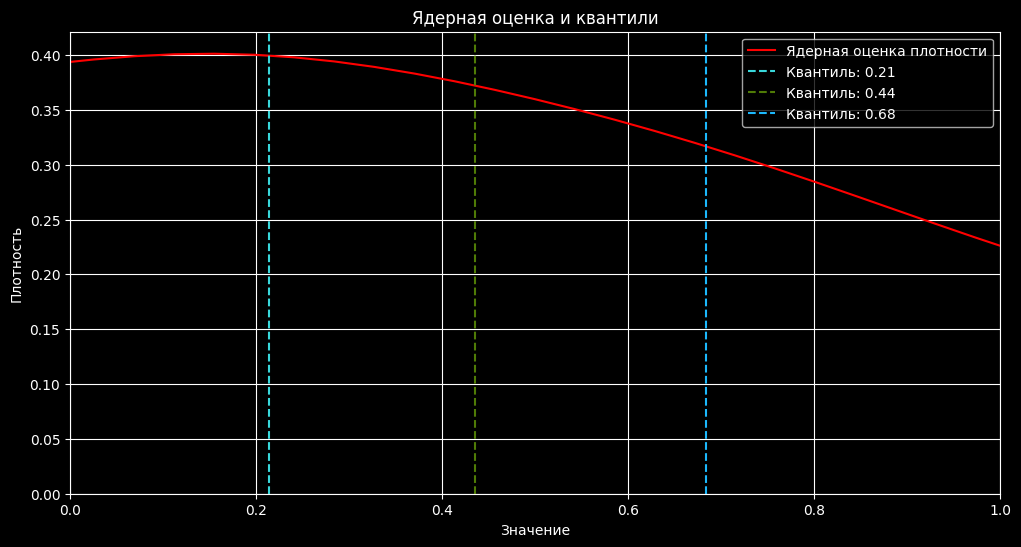

In [26]:
kde = stats.gaussian_kde(data)

kde_sample = kde.resample(200000).reshape(-1)
kde_quantiles = np.percentile(kde_sample, [25, 50, 75])

plt.figure(figsize=(12, 6))
plt.xlim(0, 1)

sns.kdeplot(data, label='Ядерная оценка плотности', color='red')
for q in quantile_values:
    plt.axvline(q, linestyle='--', label=f'Квантиль: {q:.2f}', color = (random.random(), random.random(), random.random()))

plt.title('Ядерная оценка и квантили')
plt.xlabel('Значение')
plt.ylabel('Плотность')
plt.legend()
plt.grid()
plt.show()

Брал квантили, которые взяты из обрезанного распределения в пределах \[0,1]